# Import Packages

In [1]:
import tensorflow as tf
print('tensorflow:',tf.__version__)
import keras
print('Keras:',keras.__version__)
from keras import *
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os,sys
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from keras.callbacks import History 
history = History()
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

tensorflow: 2.4.1
Keras: 2.4.3


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


set paths for train, test and validation and load dataset to Generator 

In [3]:
train_path = './dataset/train'
test_path = './dataset/test'
val_path = './dataset/val'

train_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(train_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=32)

test_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=32)

valid_batches = ImageDataGenerator().flow_from_directory(val_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=16)

Found 417 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Function for confution matrix

In [4]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
  
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without normalization")
  
  print(cm)
  
  thresh = cm.max() / 2.
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
            horizontalalignment ="center",
            color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Load Training Neural Network Architecture (VGG16)

In [5]:
vgg16_model = keras.applications.vgg16.VGG16()

In [6]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [7]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [8]:
for layer in model.layers:
    layer.trainable = False

In [9]:
model.add(Dense(2, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [11]:
model.compile(Adam(lr=.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_checkpoint = ModelCheckpoint('vgg16.hdf5', monitor='accuracy',verbose=0, save_best_only=True, mode='max')

Training Initiation

In [13]:
history = model.fit(train_batches, 
                    steps_per_epoch=10, 
                    validation_data= valid_batches, 
                    validation_steps=1,
                    epochs=50,
                    verbose=1,
                    callbacks=[model_checkpoint])

Epoch 1/50
10/10 [==============================] - 17s 887ms/step - loss: 0.7513 - accuracy: 0.5120 - val_loss: 0.7281 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 5s 442ms/step - loss: 0.7123 - accuracy: 0.5831 - val_loss: 0.5395 - val_accuracy: 0.6875
Epoch 3/50
10/10 [==============================] - 4s 472ms/step - loss: 0.6398 - accuracy: 0.6263 - val_loss: 0.6732 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 4s 419ms/step - loss: 0.7026 - accuracy: 0.6291 - val_loss: 0.6396 - val_accuracy: 0.5625
Epoch 5/50
10/10 [==============================] - 4s 413ms/step - loss: 0.7286 - accuracy: 0.5852 - val_loss: 0.6292 - val_accuracy: 0.5625
Epoch 6/50
10/10 [==============================] - 4s 407ms/step - loss: 0.7241 - accuracy: 0.5697 - val_loss: 0.6384 - val_accuracy: 0.6250
Epoch 7/50
10/10 [==============================] - 4s 385ms/step - loss: 0.6715 - accuracy: 0.6171 - val_loss: 0.5024 - val_accuracy: 0.6875
Epoch

Training accuracy & Validation accuracy Plot

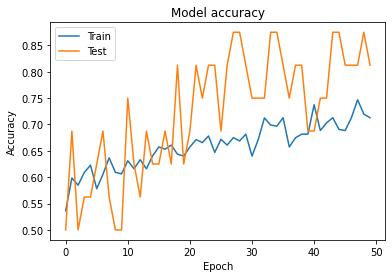

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Training loss & Validation loss Plot

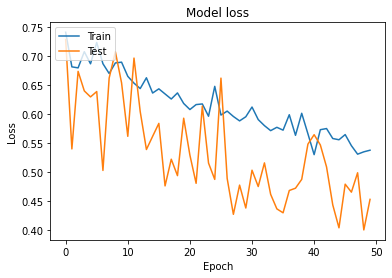

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if(ims.shape[-1] != 3):
      ims = ims.transpose ((0,2,3,1))
  f = plt.figure(figsize = figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
  for i in range(len(ims)):
    sp = f.add_subplot (rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize =10)
    plt.imshow(ims[i], interpolation=None if interp else 'none')

In [17]:
test_batches_fine = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=60)

Found 60 images belonging to 2 classes.


In [18]:
test_imgs, test_labels = next(test_batches_fine)

[1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1]
60


C:\Users\bohor\Anaconda3\envs\BN\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


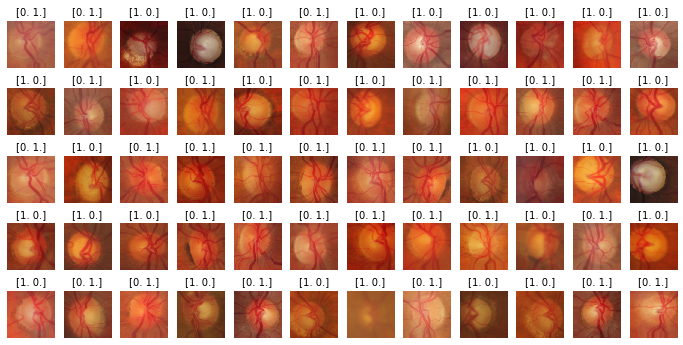

In [19]:
x_labels = test_labels.argmax(axis=1)
print(x_labels)
print(len(test_labels))
plots(test_imgs, titles=test_labels)

In [20]:
x_labels

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1], dtype=int64)

In [21]:
predictions = model.predict_generator(test_batches_fine, steps=1, verbose=0)

C:\Users\bohor\Anaconda3\envs\BN\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [22]:
y_labels = predictions.argmax(axis=1)
y_labels

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], dtype=int64)

In [23]:
cm = confusion_matrix(x_labels, y_labels)

In [24]:
cm_plot_labels = ['Glaucoma','Normal']

Confusion Matrix without normalization
[[25  5]
 [ 8 22]]


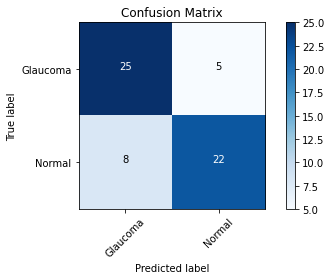

In [25]:
plot_confusion_matrix(cm, cm_plot_labels, title ='Confusion Matrix')

In [26]:
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

Sensitivity =(TP)/(TP +FN)

Specificity =(TN)/(TN+ FP)

Precision =(TP)/(TP + FP)

F1− score =(2TP)/(2TP + FP+ FN)

Accuracy =(TP + TN)/(TP + FP +FN+ TN)

In [27]:
Sensitivity =(TP)/(TP +FN)
print(Sensitivity)

0.7575757575757576


In [28]:
Specificity =(TN)/(TN+ FP)
print(Specificity)

0.8148148148148148


In [29]:
Precision =(TP)/(TP + FP)
print(Precision)

0.8333333333333334


In [30]:
F1score =(2*TP)/(2*TP + FP+ FN)
print(F1score)

0.7936507936507936


In [31]:
Accuracy =(TP + TN)/(TP + FP +FN+ TN)
print(Accuracy)

0.7833333333333333


In [32]:
from sklearn import metrics
pred =[]
for i in predictions:
    pred.append(i[1])
print ("AUC",metrics.roc_auc_score(x_labels, pred))

AUC 0.8266666666666667


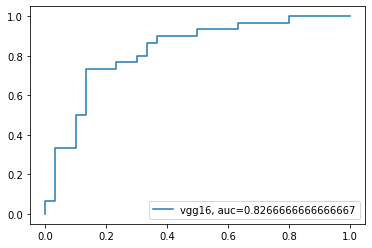

In [33]:
fpr, tpr, thresh = metrics.roc_curve(x_labels, pred)
auc = metrics.roc_auc_score(x_labels, pred)
plt.plot(fpr,tpr,label="vgg16, auc="+str(auc))
plt.legend(loc=0)